# Audio source separation

Requires `scipy==1.10.1` and `mdct==0.4`. 

Execute the next cell to install these libraries then restart the kernel.

In [1]:
# !pip install scipy==1.10.1 mdct==0.4

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import hamming
from scipy.spatial.distance import cdist

import IPython.display as ipd
from mdct.fast import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [3]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.display(ipd.Audio(data.T, rate=rate))

T = 220501, M = 2


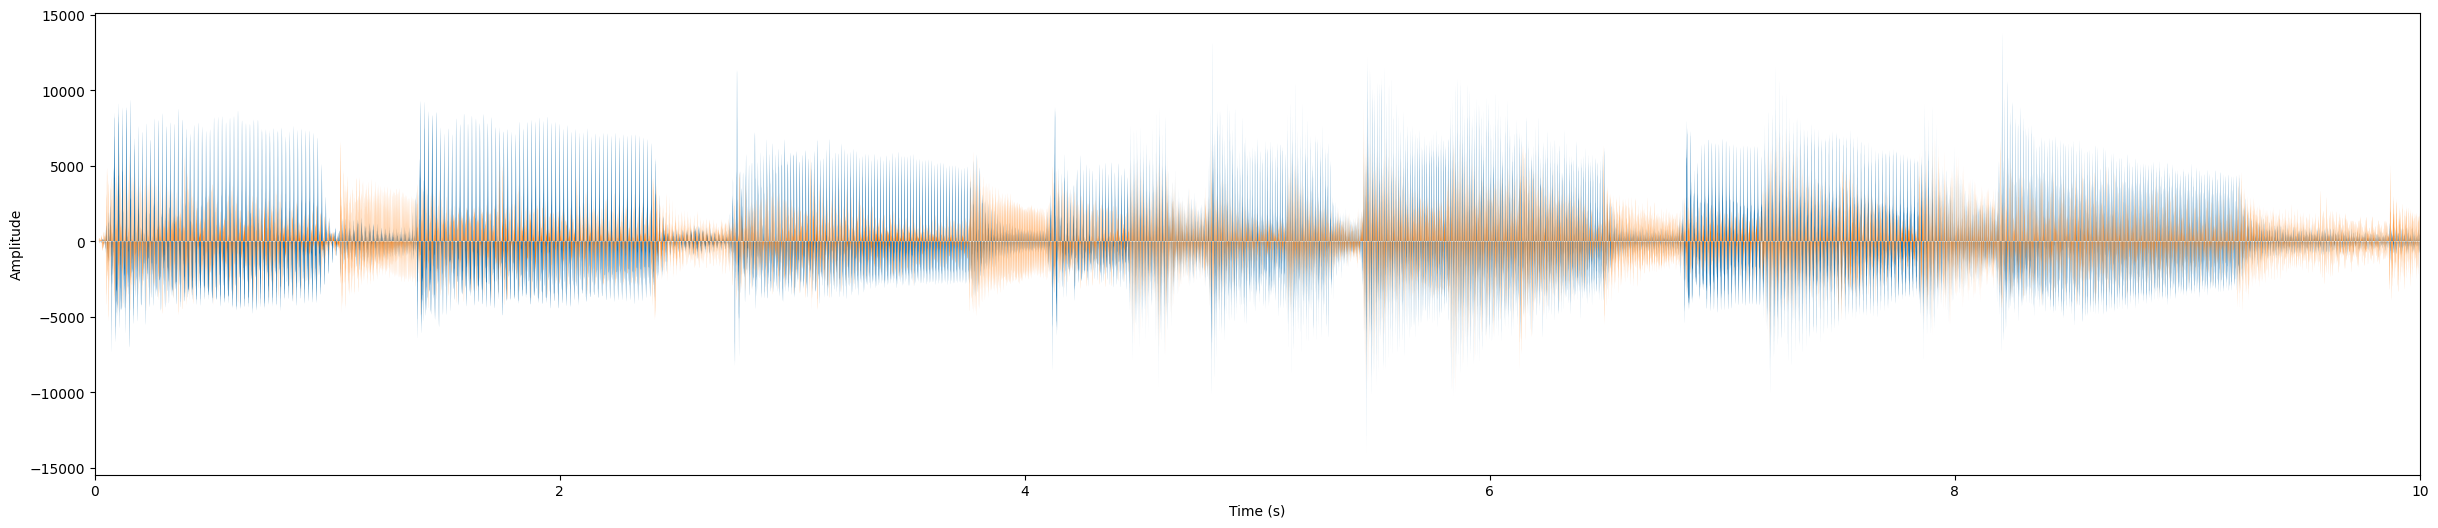

In [4]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

In [5]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

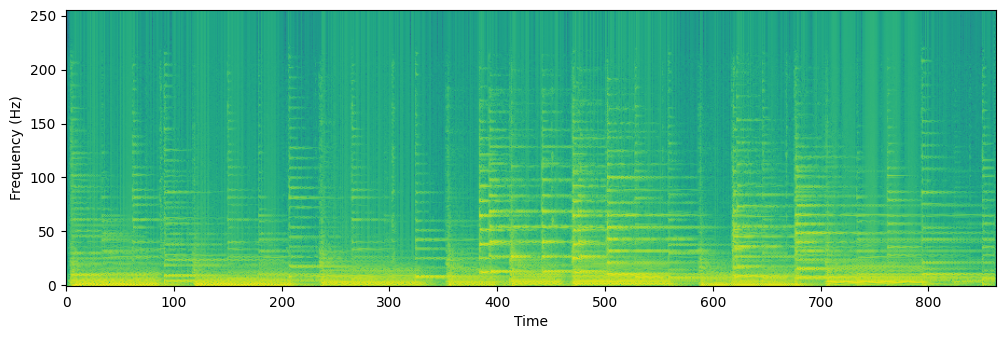

In [6]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

# Work to do

1. Open file `mix.wav` and load it in a $T × M$ matrix $x(t, m)$, where $M = 2$ and $T$ is the number of samples. Use your headphones to listen to the mixture. What is the number $K$ of instruments that you can hear? From which direction do you perceive them?

The spectrogram of `mix.wav` shows distinct horizontal lines and bands, indicating the presence of harmonic structures typically associated with musical instruments. These lines suggest periodic sounds, characteristic of pitched musical instruments. Visually, the presence of multiple harmonic bands at different frequency ranges and times hints at the presence of multiple instruments. Lower frequencies might represent bass instruments, while higher frequencies could correspond to instruments like guitars, pianos, or vocal harmonics. 

Upon listening to the `mix.wav` file, three distinct instruments can be identified: a bass coming from the left, a guitar from the right, and a piano centrally positioned. This spatial differentiation provides crucial information for the DUET method, allowing for the effective separation of these sources based on their unique spatial cues and positions within the stereo field.

2. Plot the temporal dispersion diagram, defined as the set of points in the plane of coordinates $(x(t, 1), x(t, 2))$ for all $t$ (in order to plot a set of points, you can use the Matlab function plot or the Python function `matplotlib.pyplot.plot` with parameter $x$, and you can normalize the axes with the Matlab instruction axis equal or the Python Matplotlib function `axis(’equal’)`). Can you distinguish the directions of the sources?

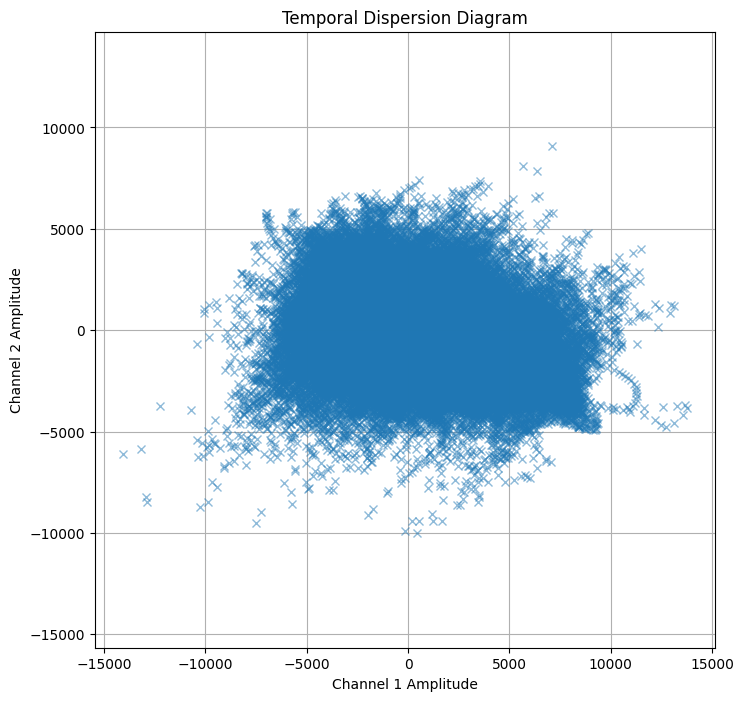

In [7]:
# Function to plot the temporal dispersion diagram
def plot_temporal_dispersion(data):
    plt.figure(figsize=(8, 8))
    plt.plot(data[:, 0], data[:, 1], 'x', alpha=0.5)
    plt.xlabel('Channel 1 Amplitude')
    plt.ylabel('Channel 2 Amplitude')
    plt.title('Temporal Dispersion Diagram')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Plot the temporal dispersion diagram
plot_temporal_dispersion(x)

The plot reveals a dense cluster of points centered around the origin, indicating the overlap of the signals from the different instruments in both channels. The dispersion and spread of points indicate the variation in amplitude between the left and right channels.

The concentration and spread of the points can help in distinguishing the directions of the sources. Points that are spread out diagonally indicate a stronger presence in one channel over the other, while points closer to the origin represent more balanced contributions from both channels. Although is not very clear, given the auditory analysis, it can be infered that the bass (left), guitar (right), and piano (center) contribute to this distribution. The wider spread of points may correspond to the bass and guitar, which are panned more to the left and right, respectively. The denser cluster near the center likely represents the piano, which is panned centrally.

3. Compute the MDCT $X(f, n, m)$ of the two stereophonic channels $x(t, m)$ (you can use the Matlab function `wmdct`, with $F = 512$ frequency bands and the window `sqrthann`, or the Python function `mdct`). Plot the corresponding time-frequency representations $|X(f, n, m)|^2$ (you can use the Matlab function `plotwmdct` or the Python function `matplotlib.pyplot.imshow`).

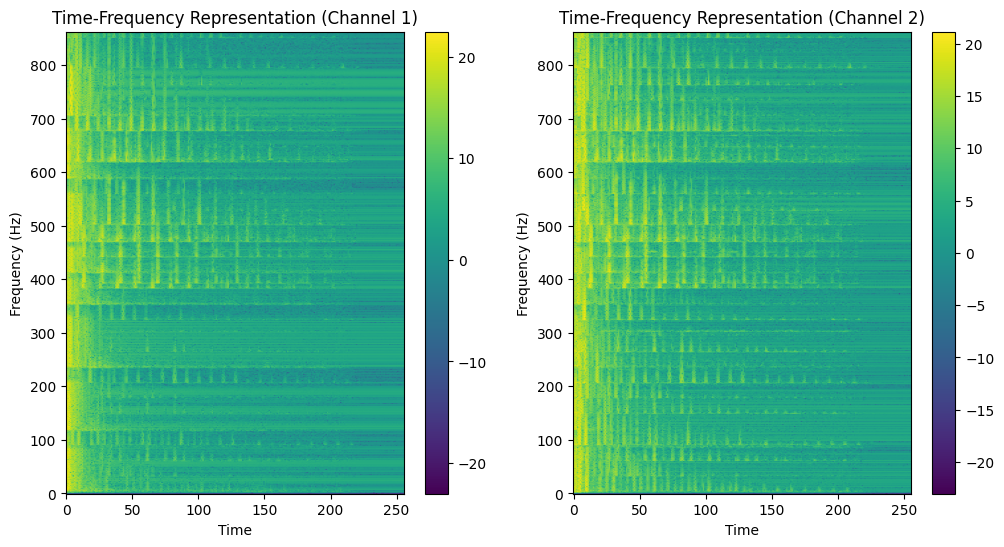

In [8]:
# Compute MDCT for both channels
X_channel1 = mdct(x[:, 0], window=hamming, framelength=512)
X_channel2 = mdct(x[:, 1], window=hamming, framelength=512)

# Compute the magnitude squared of the MDCT coefficients
X_magnitude_squared_1 = np.abs(X_channel1)**2
X_magnitude_squared_2 = np.abs(X_channel2)**2

plt.figure(figsize=(12, 6))

# Plot the time-frequency representation for channel 1
plt.subplot(1, 2, 1)
plt.imshow(np.log(X_magnitude_squared_1.T + 1e-10), origin='lower', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation (Channel 1)')
plt.colorbar()

# Plot the time-frequency representation for channel 2
plt.subplot(1, 2, 2)
plt.imshow(np.log(X_magnitude_squared_2.T + 1e-10), origin='lower', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation (Channel 2)')
plt.colorbar()
plt.show()

4. Plot the time-frequency dispersion diagram, defined as the set of points in the plane of affix $Z(f, n)$ for all $f$ and $n$. Can you distinguish the directions of the sources? How do you explain it?

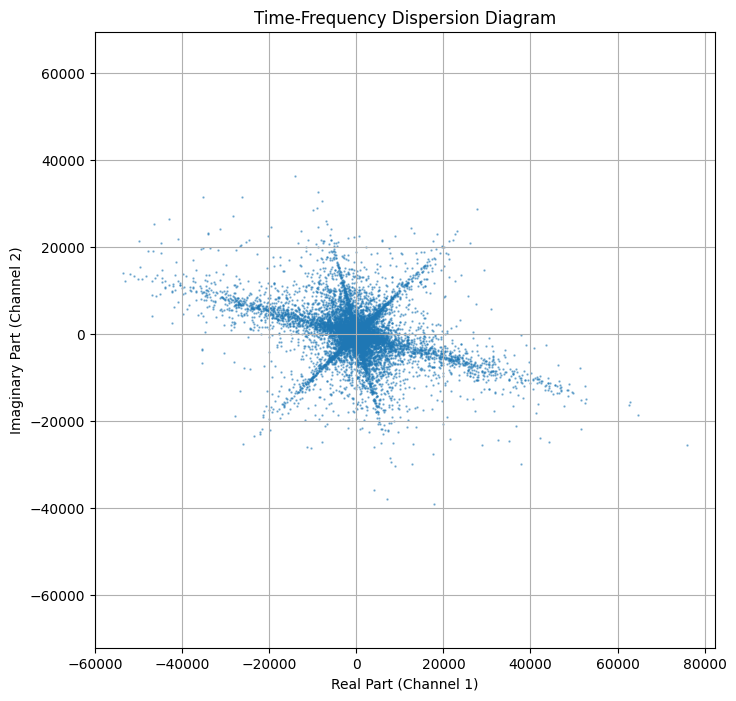

In [9]:
# Combine MDCT coefficients to form the complex plane of affix Z(f, n)
Z = X_channel1 + 1j * X_channel2

# Plot the time-frequency dispersion diagram
plt.figure(figsize=(8, 8))
plt.scatter(Z.real.flatten(), Z.imag.flatten(), alpha=0.5, s=0.5)
plt.xlabel('Real Part (Channel 1)')
plt.ylabel('Imaginary Part (Channel 2)')
plt.title('Time-Frequency Dispersion Diagram')
plt.axis('equal')
plt.grid(True)
plt.show()

The plot shows several distinct clusters radiating outwards from the origin, each cluster representing a different source in the mixture. The central cluster indicates the presence of a source that is more balanced between the two channels, likely the centrally positioned piano. The clusters extending to the left and right indicate sources that are panned more towards the left and right channels, respectively. This aligns with the auditory analysis of the bass (left) and guitar (right).

**Direction of Sources:**
   - **Bass (Left):** Points that form a cluster extending towards the negative side of the real axis (Channel 1) and closer to the origin on the imaginary axis (Channel 2) represent the bass instrument, which is predominantly in the left channel.
   - **Guitar (Right):** Points that form a cluster extending towards the positive side of the real axis (Channel 1) and closer to the origin on the imaginary axis (Channel 2) represent the guitar, which is predominantly in the right channel.
   - **Piano (Center):** Points clustered around the origin in both axes represent the piano, which is balanced between both channels and centrally panned.

The time-frequency dispersion diagram effectively visualizes the spatial characteristics of the sources due to the MDCT's ability to separate the sources in the time-frequency domain. The distinct clustering patterns arise because each source contributes uniquely to the left and right channels, resulting in different spatial footprints in the complex plane. The sparsity assumption of the DUET method (where only one source is dominant in each time-frequency bin) allows for clear separation and identification of these sources based on their spatial characteristics.

5. Plot the histogram of the arguments of the points of affix $Z(f, n)$ for all $f$ and $n$ (you can use the Matlab function `atan` or the Python function `numpy.arctan` to compute the arguments modulo $\pi$, between $−\frac{\pi}{2}$ and $+\frac{\pi}{2}$, and the Matlab function `hist` or the Python function `matplotlib.pyplot.hist` to compute the histogram, whose number of classes has to be tuned so as to make the directions of the sources clearly visible). Estimate the angles $\theta(k)$ (you can determine these values graphically from the histogram)

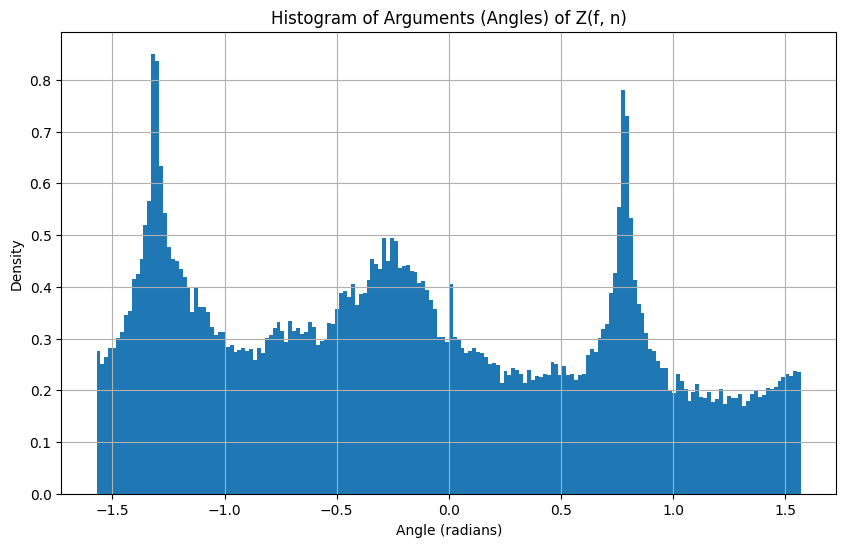

In [10]:
# Compute the angles (arguments) of the complex points Z(f, n)
angles = np.arctan2(Z.imag, Z.real)

# Plot the histogram of the angles
plt.figure(figsize=(10, 6))
plt.hist(angles.flatten(), bins=180, range=(-np.pi/2, np.pi/2), density=True)
plt.xlabel('Angle (radians)')
plt.ylabel('Density')
plt.title('Histogram of Arguments (Angles) of Z(f, n)')
plt.grid(True)
plt.show()

From the histogram of the arguments (angles) of $Z(f, n)$, we can estimate the angles $\theta(k)$ corresponding to each source by identifying the prominent peaks in the histogram. 

The histogram shows three significant peaks at different angles. These peaks correspond to the directions of the sources in the stereo mix.

**Estimated Angles:**
   - **Peak 1:** Around $-1.3$ radians (closer to $-\pi/2$), likely corresponding to the bass which is panned to the left.
   - **Peak 2:** Around $-0.25$ radians, likely corresponding to the piano which is centrally panned.
   - **Peak 3:** Around $1.3$ radians (closer to $\pi/2$), likely corresponding to the guitar which is panned to the right.

Based on the visual inspection of the histogram, the estimated angles $\theta(k)$ for the sources are approximately:

- $\theta_1 \approx -1.3$ radians (Bass)
- $\theta_2 \approx -0.25$ radians (Piano)
- $\theta_3 \approx 1.3$ radians (Guitar)

These angles represent the spatial positions of the sources in the stereo field, with the bass being on the left, the piano in the center, and the guitar on the right. These estimations align with the previous auditory and visual analyses of the stereo mix.

6. In order to estimate the active source at every time-frequency bin $(f, n)$, you can look for the source $k$ whose angle $\theta(k)$ is closest to the argument of $Z(f, n)$, modulo $\pi$ (you can use a deviation measure invariant modulo $\pi$, for instance $|\sin (\theta(k) − ∠Z(f, n))|$). Then generate the binary masks $B\in \{0, 1\}$, such that $B(f, n, k)$ is equal to 1 if source $k$ is active at $(f, n)$, or $0$ otherwise.

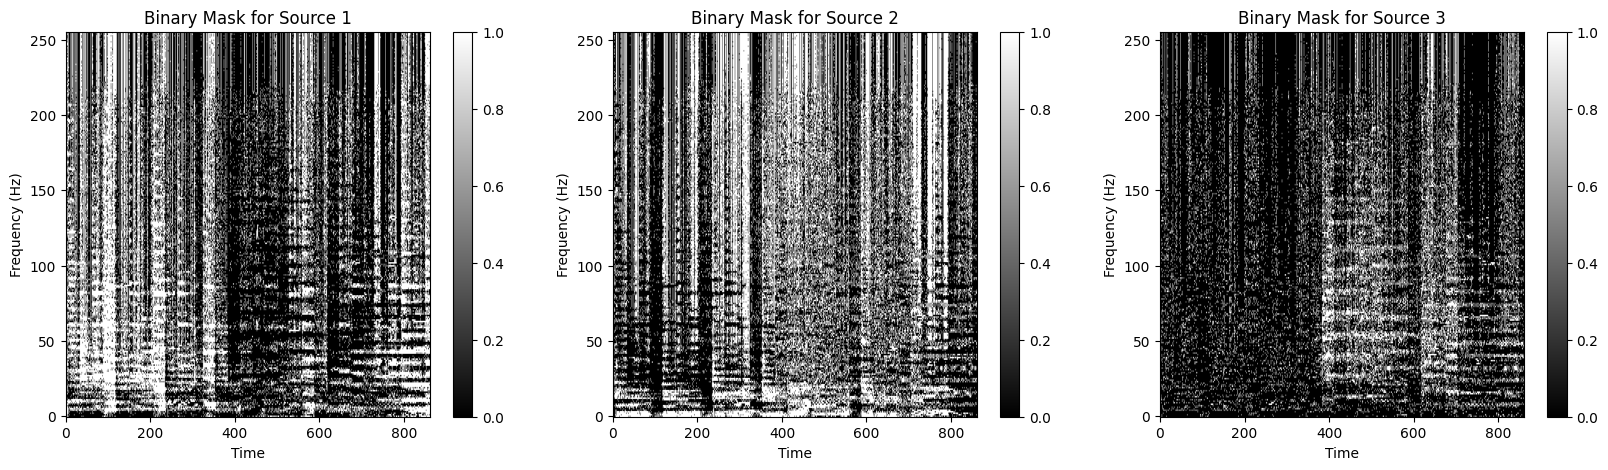

In [11]:
# Previously estimated angles theta(k)
theta_k = [-1.3, 0.25, 1.3]  

# Compute the angles (arguments) of the complex points Z(f, n)
angles = np.arctan2(Z.imag, Z.real)

# Initialize the binary masks
num_sources = len(theta_k)
B = np.zeros((angles.shape[0], angles.shape[1], num_sources))

# Compute the deviation measure for each source and generate binary masks
deviation = np.zeros((angles.shape[0], angles.shape[1], num_sources))

for k in range(num_sources):
    deviation[:, :, k] = np.abs(np.sin(angles - theta_k[k]))

# Assign each bin to the source with the smallest deviation
min_deviation_indices = np.argmin(deviation, axis=2)

for k in range(num_sources):
    B[:, :, k] = (min_deviation_indices == k)

# Visualize the binary masks for each source
plt.figure(figsize=(20, 5))
for k in range(num_sources):
    plt.subplot(1, 3, k+1)
    plt.imshow(B[:, :, k], origin='lower', aspect='auto', cmap='gray')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Binary Mask for Source {k+1}')
    plt.colorbar()

plt.show()

7. Apply masks $B$ to the $MDCT X(f, n, m)$ in order to estimate the MDCT of the stereophonic images $Y(f, n, m, k)$. Then reconstruct the images $y(t, m, k)$ of the source signals by applying the inverse MDCT (you can use the Matlab function `iwmdct` or the Python function `imdct`).

In [ ]:
# Apply the masks to the MDCT to isolate each source
sources = []

for k in range(num_sources):
    X_channel1_masked = X_channel1 * B[:, :, k]
    X_channel2_masked = X_channel2 * B[:, :, k]

    # Inverse MDCT to reconstruct the time-domain signals for each source
    source1 = imdct(X_channel1_masked, window = hamming, framelength = 512)
    source2 = imdct(X_channel2_masked, window = hamming, framelength = 512)
    
    # Combine the two channels
    source = np.vstack((source1, source2)).T
    sources.append(source)
    
    # Save the separated sources to WAV files
    wavfile.write(f'source_{k+1}.wav', rate, source.astype(np.int16))

for k, source in enumerate(sources):
    plot_sound(source, rate, title=f'Separated Source {k+1}')